# Лабораторная работа №5

## Ансамбли моделей машинного обучения

### Цель лабораторной работы
Изучение ансамблей моделей машинного обучения.

### Задание
1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

# Ход выполнения лабораторной работы

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style="ticks")

In [2]:
col_list = ['Pelvic_incidence',
               'Pelvic_tilt',
               'Lumbar_lordosis_angle',
               'Sacral_slope',
               'Pelvic_radius',
               'Degree_spondylolisthesis',
               'Pelvic_slope',
               'Direct_tilt',
               'Thoracic_slope',
               'Cervical_tilt',
               'Sacrum_angle',
               'Scoliosis_slope',
               'To_drop']
data = pd.read_csv('Dataset_spine.csv', names=col_list, header=1, sep=",")
data.drop('To_drop', axis=1, inplace=True)

In [3]:
data.head()

,Pelvic_incidence,Pelvic_tilt,Lumbar_lordosis_angle,Sacral_slope,Pelvic_radius,Degree_spondylolisthesis,Pelvic_slope,Direct_tilt,Thoracic_slope,Cervical_tilt,Sacrum_angle,Scoliosis_slope
39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal
40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,0.789993,29.3230,12.0036,10.40462,-1.512209,9.6548,Abnormal


In [4]:
data.isnull().sum()

Pelvic_incidence            0
Pelvic_tilt                 0
Lumbar_lordosis_angle       0
Sacral_slope                0
Pelvic_radius               0
Degree_spondylolisthesis    0
Pelvic_slope                0
Direct_tilt                 0
Thoracic_slope              0
Cervical_tilt               0
Sacrum_angle                0
Scoliosis_slope             0
dtype: int64

Пропуски данных отсутствуют.

In [5]:
#Кодирование категориальных признаков
data['Scoliosis_slope'] = data['Scoliosis_slope'].map({'Abnormal': 1, 'Normal': 0})

#### В качестве метрики для решения задачи классификации будем использовать: Precision - доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.

Разработаем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества.

In [6]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()   

Для задачи классификации будем использовать случайный лес и градиентный бустинг.

### Формирование обучающей и тестовой выборок

In [7]:
data.columns

Index(['Pelvic_incidence', 'Pelvic_tilt', 'Lumbar_lordosis_angle',
       'Sacral_slope', 'Pelvic_radius', 'Degree_spondylolisthesis',
       'Pelvic_slope', 'Direct_tilt', 'Thoracic_slope', 'Cervical_tilt',
       'Sacrum_angle', 'Scoliosis_slope'],
      dtype='object')

In [8]:
data.dtypes

Pelvic_incidence            float64
Pelvic_tilt                 float64
Lumbar_lordosis_angle       float64
Sacral_slope                float64
Pelvic_radius               float64
Degree_spondylolisthesis    float64
Pelvic_slope                float64
Direct_tilt                 float64
Thoracic_slope              float64
Cervical_tilt               float64
Sacrum_angle                float64
Scoliosis_slope               int64
dtype: object

In [9]:
# Признаки для задачи классификации
class_cols = ['Pelvic_incidence',
               'Pelvic_tilt',
               'Lumbar_lordosis_angle',
               'Degree_spondylolisthesis',
               ]

In [10]:
X = data[class_cols]
Y = data['Scoliosis_slope']
X.shape

(309, 4)

In [11]:
# С использованием метода train_test_split разделим выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [12]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((231, 4), (78, 4), (231,), (78,))

### Обучение моделей

In [13]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [14]:
def train_model(model_name, model, MetricLogger):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    precision = precision_score(Y_test.values, Y_pred)
    
    MetricLogger.add('precision', model_name, precision)

    print('*****************************************************')
    print(model_name)
    print(model)
    print("precision_score:", precision)

In [15]:
train_model('Случайный лес', RandomForestClassifier(), clasMetricLogger)
train_model('Градиентный бустинг', GradientBoostingClassifier(), clasMetricLogger)

*****************************************************
Случайный лес
RandomForestClassifier()
precision_score: 0.7647058823529411
*****************************************************
Градиентный бустинг
GradientBoostingClassifier()
precision_score: 0.7346938775510204


### Оценка качества моделей

In [16]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision'], dtype=object)

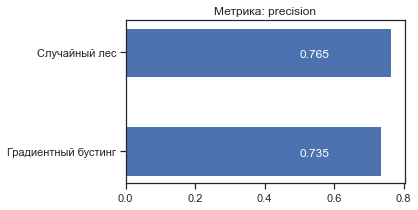

In [17]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(5, 3))

На основании метрики precision лучшим оказался случайный лес.